# Libraries

In [1]:
import os
import sys
import csv
import requests
from bs4 import BeautifulSoup
import json
import datetime
from datetime import date, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


# Data Loading

In [2]:
df = pd.read_csv('../data/processed_datav2.csv')
df.set_index('Date', inplace=True)
df.head()

,btc_price,btc_open,btc_high,btc_low,btc_change,gold_price,gold_open,gold_high,gold_low,gold_change,...,us30_high,us30_low,us30_change,usidx_price,usidx_open,usidx_high,usidx_low,usidx_change,btc_rsi,direction
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,313.9,317.5,317.5,312.9,-0.99,1186.2,1184.0,1194.9,1167.3,0.18,...,17825.5,17757.0,-0.01,91.383,90.81,91.49,90.80,0.81,21.173357,0
2015-01-02,315.1,313.6,316.0,313.0,0.40,1186.2,1184.0,1194.9,1167.3,0.18,...,17951.8,17731.3,0.06,91.383,90.81,91.49,90.80,0.81,21.173357,1
2015-01-03,282.0,314.8,314.8,282.0,-10.51,1186.2,1184.0,1194.9,1167.3,0.18,...,17951.8,17731.3,0.06,91.383,90.81,91.49,90.80,0.81,21.173357,0
2015-01-04,258.8,282.0,288.9,258.8,-8.23,1186.2,1184.0,1194.9,1167.3,0.18,...,17951.8,17731.3,0.06,91.383,90.81,91.49,90.80,0.81,21.173357,0
2015-01-05,273.2,261.0,276.5,260.5,5.57,1204.0,1187.8,1207.5,1177.8,1.50,...,17821.3,17475.9,-1.86,91.622,91.73,92.05,91.55,0.26,21.173357,1


<Axes: xlabel='direction'>

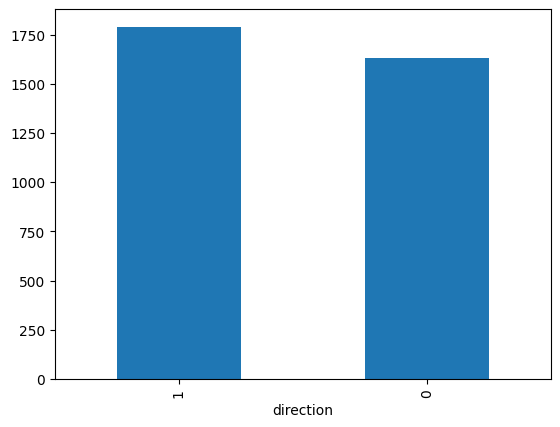

In [3]:
df['direction'].value_counts().plot(kind='bar')

# Model Training

In [4]:
features = df[['btc_price', 'btc_open', 'btc_high', 'btc_low', 'btc_change', 'gold_price', 'gold_open', 'gold_high', 'gold_low', 'gold_change', 
               'sp_price', 'sp_open', 'sp_high', 'sp_low', 'sp_change', 'us30_price', 'us30_open', 'us30_high', 'us30_low', 'us30_change', 
               'usidx_price', 'usidx_open', 'usidx_high', 'usidx_low', 'usidx_change', 'btc_rsi']].values
target = df['direction'].values


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)



In [5]:
features[1]

array([ 3.15100000e+02,  3.13600000e+02,  3.16000000e+02,  3.13000000e+02,
        4.00000000e-01,  1.18620000e+03,  1.18400000e+03,  1.19490000e+03,
        1.16730000e+03,  1.80000000e-01,  2.05820000e+03,  2.05890000e+03,
        2.07240000e+03,  2.04600000e+03, -3.00000000e-02,  1.78330000e+04,
        1.78231000e+04,  1.79518000e+04,  1.77313000e+04,  6.00000000e-02,
        9.13830000e+01,  9.08100000e+01,  9.14900000e+01,  9.08000000e+01,
        8.10000000e-01,  2.11733569e+01])

In [6]:
X_train[1]

array([ 1.64590000e+04,  1.65190000e+04,  1.66970000e+04,  1.63900000e+04,
       -3.60000000e-01,  1.75400000e+03,  1.75100000e+03,  1.76120000e+03,
        1.74590000e+03,  0.00000000e+00,  4.02610000e+03,  4.02330000e+03,
        4.03400000e+03,  4.02080000e+03, -3.00000000e-02,  3.43685000e+04,
        3.42525000e+04,  3.43830000e+04,  3.41940000e+04,  3.40000000e-01,
        1.05917000e+02,  1.05845000e+02,  1.06345000e+02,  1.05605000e+02,
       -5.00000000e-02,  4.51121573e+01])

In [7]:
class PrintEpochProgress(Callback):
    def __init__(self, print_epochs):
        super(PrintEpochProgress, self).__init__()
        self.print_epochs = print_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_epochs == 0:
          val_loss = logs.get('val_loss')
          val_accuracy = logs.get('val_accuracy')
          print(f"Epoch {epoch + 1}/{self.params['epochs']}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

In [8]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import plot_model

In [9]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)



# Define the DNN model
def build_dnn(input_shape):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(128, activation='relu'),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(64, activation='relu'),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(32, activation='relu'),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(16, activation='relu'),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(8, activation='relu'),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Build the model
input_shape = X_train.shape[1:]
model = build_dnn(input_shape)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print_progress_callback = PrintEpochProgress(print_epochs=50)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 26)                0         
                                                                 
 dense (Dense)               (None, 256)               6912      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0

In [60]:
# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=0, callbacks=[print_progress_callback])

Epoch 1/10
218/218 [==============================] - 9s 29ms/step - loss: 0.6909 - accuracy: 0.5287 - val_loss: 0.6940 - val_accuracy: 0.4991
Epoch 2/10
218/218 [==============================] - 6s 25ms/step - loss: 0.6861 - accuracy: 0.5425 - val_loss: 0.6976 - val_accuracy: 0.5101
Epoch 3/10
218/218 [==============================] - 6s 26ms/step - loss: 0.6854 - accuracy: 0.5466 - val_loss: 0.6935 - val_accuracy: 0.5211
Epoch 4/10
218/218 [==============================] - 6s 26ms/step - loss: 0.6840 - accuracy: 0.5379 - val_loss: 0.6985 - val_accuracy: 0.5101
Epoch 5/10
218/218 [==============================] - 6s 26ms/step - loss: 0.6820 - accuracy: 0.5517 - val_loss: 0.6910 - val_accuracy: 0.5064
Epoch 6/10
218/218 [==============================] - 6s 26ms/step - loss: 0.6813 - accuracy: 0.5595 - val_loss: 0.7200 - val_accuracy: 0.4991
Epoch 7/10
218/218 [==============================] - 6s 26ms/step - loss: 0.6803 - accuracy: 0.5480 - val_loss: 0.6955 - val_accuracy: 0.5266

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the metrics
labels = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('dnn.h5')

# Model import

In [19]:
from tensorflow.keras.models import load_model


loaded_model = load_model('../models/dnn.h5')


predictions = loaded_model.predict(X_test)


33/33 [==============================] - 0s 2ms/step


In [20]:
y_pred_binary = np.round(predictions).astype(int)

In [21]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Precision, Recall, F1 Score
report = classification_report(y_test, y_pred_binary)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, predictions)


In [12]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       471
           1       0.95      0.99      0.97       553

    accuracy                           0.97      1024
   macro avg       0.97      0.96      0.97      1024
weighted avg       0.97      0.97      0.97      1024



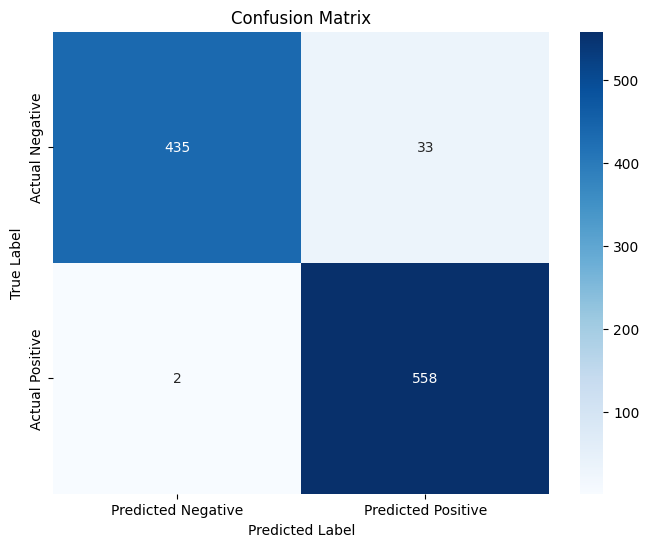

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
X_test[-1][4]

0.46

In [23]:
loaded_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 26)                0         
                                                                 
 dense_40 (Dense)            (None, 256)               6912      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 64)               